Stage 1: Basic Feature Selection (Data Understanding & Initial Filtering)

In [22]:
# 📦 Imports

!pip install missingno statsmodels
!pip install category_encoders
!pip install mlxtend
!pip install optuna
!pip install pyswarms
import missingno as msno


import pandas as pd
import numpy as np
import re


import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew



from sklearn.feature_selection import VarianceThreshold
from scipy.stats import skew, kurtosis, ttest_ind, chisquare

# 📌 Load your dataset (Make sure it's uploaded in the same folder)

df = pd.read_csv("train.csv")

target_column = input("Enter the name of the target column: ")

original_df = df.copy()
y = df[target_column]
df.drop(columns=[target_column], inplace=True)#Then removes it from the main feature set df to avoid data leakage


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Enter the name of the target column:  Survived


In [23]:


def step1_data_profiling(df: pd.DataFrame) -> pd.DataFrame:
    """
    Step 1: Data Profiling, Completeness, and Quality Check
    Args:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: Same DataFrame (helper columns cleaned), and logs printed
    """
    try:
        print("🔍 Step 1: Data Profiling")

        # Basic Structure
        print("Shape of dataset:", df.shape)
        print("\nFeature types:\n", df.dtypes)
        print("\nSummary statistics:\n", df.describe(include='all'))

        # Type Classification
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

        print("\nNumerical_cols:", numerical_cols)
        print("Categorical_cols:", categorical_cols)

        # Column-wise completeness
        completeness_col = df.notnull().mean().sort_values(ascending=True)
        print("\n📌 Column-wise Data Completeness (% of non-missing values):")
        print((completeness_col * 100).round(2))

        # Row-wise completeness
        df['row_completeness'] = df.notnull().mean(axis=1)
        low_quality_rows = df[df['row_completeness'] < 0.5]
        print(f"\n📌 Rows with <50% completeness: {len(low_quality_rows)} / {df.shape[0]}")
        df.drop(columns=['row_completeness'], inplace=True)

        # Data Quality Issues Report
        invalid_values_report = {}

        # Check numerical columns
        for col in numerical_cols:
            if df[col].dtype in ['int64', 'float64']:
                negatives = (df[col] < 0).sum()
                infs = np.isinf(df[col]).sum()
                nans = df[col].isna().sum()
                if negatives > 0 or infs > 0:
                    invalid_values_report[col] = {
                        "negatives": negatives,
                        "infs": infs,
                        "nulls": nans
                    }

        # Check categorical columns
        for col in categorical_cols:
            non_alpha = df[col].astype(str).apply(
                lambda x: not bool(re.match("^[a-zA-Z0-9 _-]*$", x))
            ).sum()
            if non_alpha > 0:
                invalid_values_report[col] = {
                    "non-alphanumeric entries": non_alpha
                }

        # Print report
        if invalid_values_report:
            print("\n⚠️ Data Quality Issues Found:")
            for col, issues in invalid_values_report.items():
                print(f" - {col}: {issues}")
        else:
            print("\n✅ No major data quality issues detected.")

        print("✅ Step 1 complete.\n")
        return df

    except Exception as e:
        print(f"❌ Error in Step 1 - Data Profiling: {e}")
        return df


df = step1_data_profiling(df)


🔍 Step 1: Data Profiling
Shape of dataset: (891, 11)

Feature types:
 PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Summary statistics:
         PassengerId      Pclass                 Name   Sex         Age  \
count    891.000000  891.000000                  891   891  714.000000   
unique          NaN         NaN                  891     2         NaN   
top             NaN         NaN  Dooley, Mr. Patrick  male         NaN   
freq            NaN         NaN                    1   577         NaN   
mean     446.000000    2.308642                  NaN   NaN   29.699118   
std      257.353842    0.836071                  NaN   NaN   14.526497   
min        1.000000    1.000000                  NaN   NaN    0.420000   
25%      223.500000    2.000000                  

In [24]:
df.head()



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


🔍 Step 2: Missing Data Analysis

📌 Missing Value Percentages:
Cabin          77.10
Age            19.87
Embarked        0.22
Name            0.00
Pclass          0.00
PassengerId     0.00
Sex             0.00
Parch           0.00
SibSp           0.00
Fare            0.00
Ticket          0.00
dtype: float64

⚠️ Features with >40% missing values:
 - Cabin: 77.10%

📊 Heatmap of missing data pattern...


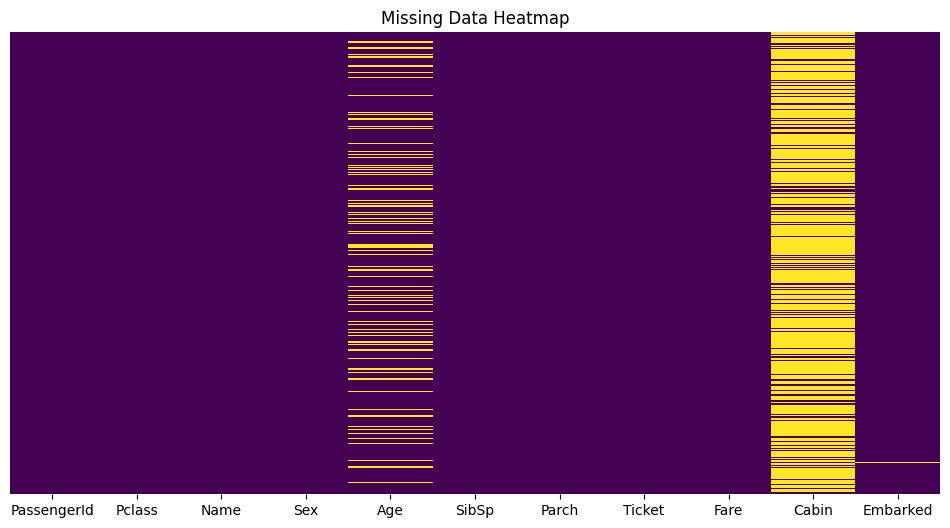


📈 Correlation Between Missing Patterns:
✅ No strong correlations in missing patterns.

🔎 Inferring Patterns of Missingness:
 - Age: Possibly MCAR or MNAR (no strong observed correlation)
 - Cabin: Likely MAR (correlated with: ['Pclass', 'Fare'])
 - Embarked: Possibly MCAR or MNAR (no strong observed correlation)
✅ Step 2 complete.



In [25]:


def step2_missing_data_analysis(df: pd.DataFrame, threshold: float = 0.4) -> pd.DataFrame:
    """
    Step 2: Analyze Missing Data Patterns, Severity, and Likely Mechanisms

    -> Calculate missing value percentages per feature
    -> Determine features with excessive missing values (>40-50% threshold)
    -> Analyze missing value correlation patterns across features
    -> Correlation between missing indicators to infer MCAR/MAR/MNAR

    Args:
        df (pd.DataFrame): Input DataFrame
        threshold (float): Proportion threshold to flag excessive missingness

    Returns:
        pd.DataFrame: Same DataFrame with logging, no mutation
    """
    try:
        print("🔍 Step 2: Missing Data Analysis")

        # 1. Percentage of missing data
        missing_percent = df.isnull().mean().sort_values(ascending=False)
        print("\n📌 Missing Value Percentages:")
        print((missing_percent * 100).round(2))

        # 2. Features above missing threshold
        high_missing_cols = missing_percent[missing_percent > threshold].index.tolist()
        if high_missing_cols:
            print(f"\n⚠️ Features with >{int(threshold*100)}% missing values:")
            for col in high_missing_cols:
                print(f" - {col}: {(missing_percent[col] * 100):.2f}%")
        else:
            print(f"\n✅ No features with >{int(threshold*100)}% missing values.")

        # 3. Visual Heatmap
        print("\n📊 Heatmap of missing data pattern...")
        plt.figure(figsize=(12, 6))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
        plt.title("Missing Data Heatmap")
        plt.show()

        # 4. Correlation between missing indicators (null masks)
        print("\n📈 Correlation Between Missing Patterns:")
        missing_corr = df.isnull().astype(int).corr()
        high_corr_pairs = [
            (col1, col2, missing_corr.loc[col1, col2])
            for col1 in missing_corr.columns
            for col2 in missing_corr.columns
            if col1 != col2 and abs(missing_corr.loc[col1, col2]) > 0.5
        ]
        if high_corr_pairs:
            for col1, col2, val in high_corr_pairs:
                print(f" - {col1} vs {col2}: Correlation = {val:.2f}")
        else:
            print("✅ No strong correlations in missing patterns.")

        # 5. Pattern Detection (MCAR / MAR / MNAR)
        print("\n🔎 Inferring Patterns of Missingness:")
        for col in df.columns[df.isnull().any()]:
            indicator = df[col].isnull().astype(int)
            temp = pd.concat([indicator, df.drop(columns=[col])], axis=1).dropna()

            # 🛠️ Filter to only numeric columns for correlation
            temp_numeric = temp.select_dtypes(include=['number'])
            if indicator.name not in temp_numeric.columns:
                temp_numeric[indicator.name] = indicator

            correlations = temp_numeric.corr()[indicator.name].drop(indicator.name).abs().sort_values(ascending=False)
            top_corr = correlations[correlations > 0.3]
            if not top_corr.empty:
                print(f" - {col}: Likely MAR (correlated with: {list(top_corr.index[:3])})")
            else:
                print(f" - {col}: Possibly MCAR or MNAR (no strong observed correlation)")

        print("✅ Step 2 complete.\n")
        return df

    except Exception as e:
        print(f"❌ Error in Step 2 - Missing Data Analysis: {e}")
        return df

df = step2_missing_data_analysis(df)



In [27]:

def step3_cardinality_and_distribution(df: pd.DataFrame,
                                       numerical_cols: list,
                                       categorical_cols: list,
                                       variance_threshold: float = 0.01) -> tuple:
    """
    Step 3: Cardinality, Distribution, and Low Variance Feature Detection

    -> Print unique counts in categorical features and flag high cardinality
    -> Print skewness and kurtosis of numerical features
    -> Detect constant and quasi-constant numerical features using variance threshold

    Args:
        df (pd.DataFrame): Input DataFrame
        numerical_cols (list): List of numerical column names
        categorical_cols (list): List of categorical column names
        variance_threshold (float): Threshold for VarianceThreshold

    Returns:
        tuple: (Updated DataFrame, updated numerical_cols list, categorical_cols list)
    """
    try:
        print("\n🔍 Step 3: Cardinality and Distribution")

        high_cardinality_features = []

        # 1. Categorical column analysis
        for col in categorical_cols:
            unique_vals = df[col].nunique()
            print(f"{col} → Unique Values: {unique_vals}")
            if unique_vals > 50:
                high_cardinality_features.append(col)

        # 2. Numerical column distribution analysis
        for col in numerical_cols:
            skew_val = skew(df[col].dropna())
            kurt_val = kurtosis(df[col].dropna())
            print(f"{col} → Skewness: {skew_val:.2f}, Kurtosis: {kurt_val:.2f}")

        # 3. Report high-cardinality categorical features
        if high_cardinality_features:
            print("\n⚠️ High-Cardinality Categorical Features Detected:")
            for col in high_cardinality_features:
                print(f" - {col} ({df[col].nunique()} unique values)")
        else:
            print("\n✅ No high-cardinality categorical features detected.")

        # 4. Variance Threshold: Constant and Quasi-Constant Feature Detection
        print("\n🧮 Detecting Constant/Quasi-Constant Features...")
        selector = VarianceThreshold(threshold=variance_threshold)
        selector.fit(df[numerical_cols])

        low_variance_cols = [col for col, var in zip(numerical_cols, selector.variances_) if var < variance_threshold]

        if low_variance_cols:
            print("⚠️ Constant/Quasi-Constant Features Detected:")
            for col in low_variance_cols:
                print(f" - {col} (Variance: {np.var(df[col]):.6f})")

            df.drop(columns=low_variance_cols, inplace=True)
            numerical_cols = [col for col in numerical_cols if col not in low_variance_cols]
        else:
            print("✅ No constant or quasi-constant features found.")

        print("✅ Step 3 complete.\n")
        return df, numerical_cols, categorical_cols

    except Exception as e:
        print(f"❌ Error in Step 3 - Cardinality and Distribution: {e}")
        return df, numerical_cols, categorical_cols


numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
     
df, numerical_cols, categorical_cols = step3_cardinality_and_distribution(df, numerical_cols, categorical_cols)



🔍 Step 3: Cardinality and Distribution
Name → Unique Values: 891
Sex → Unique Values: 2
Ticket → Unique Values: 681
Cabin → Unique Values: 147
Embarked → Unique Values: 3
PassengerId → Skewness: 0.00, Kurtosis: -1.20
Pclass → Skewness: -0.63, Kurtosis: -1.28
Age → Skewness: 0.39, Kurtosis: 0.17
SibSp → Skewness: 3.69, Kurtosis: 17.77
Parch → Skewness: 2.74, Kurtosis: 9.72
Fare → Skewness: 4.78, Kurtosis: 33.20

⚠️ High-Cardinality Categorical Features Detected:
 - Name (891 unique values)
 - Ticket (681 unique values)
 - Cabin (147 unique values)

🧮 Detecting Constant/Quasi-Constant Features...
✅ No constant or quasi-constant features found.
✅ Step 3 complete.



In [28]:
def step4_low_variance_removal(df: pd.DataFrame, numerical_cols: list,
                                quasi_constant_threshold: float = 0.95,
                                low_variance_threshold: float = 1e-4) -> tuple:
    """
    Step 4: Remove features with zero variance (constant values)
            Remove quasi-constant features (>95% same value)
            Eliminate features with extremely low variance relative to domain context

    Args:
        df (pd.DataFrame): Input DataFrame
        numerical_cols (list): List of numerical columns
        quasi_constant_threshold (float): Threshold for quasi-constant ratio (default = 0.95)
        low_variance_threshold (float): Threshold for extremely low variance (default = 0.0001)

    Returns:
        tuple: (Updated DataFrame, updated numerical_cols list)
    """
    try:
        print("\n🧹 Step 4: Constant and Quasi-Constant Feature Removal")

        low_variance_features = []
        quasi_constant_features = []
        extremely_low_variance = []

        for col in numerical_cols:
            col_series = df[col].dropna()

            # 1️⃣ Constant Features
            if col_series.nunique() == 1:
                low_variance_features.append(col)
                continue

            # 2️⃣ Quasi-Constant: >95% same value
            top_freq_ratio = col_series.value_counts(normalize=True).values[0]
            if top_freq_ratio > quasi_constant_threshold:
                quasi_constant_features.append(col)
                continue

            # 3️⃣ Extremely Low Variance
            col_variance = col_series.var()
            if col_variance < low_variance_threshold:
                extremely_low_variance.append(col)

        # Combine and remove
        to_remove = list(set(low_variance_features + quasi_constant_features + extremely_low_variance))
        df.drop(columns=to_remove, inplace=True)

        # Update numerical columns
        numerical_cols = [col for col in numerical_cols if col not in to_remove]

        # Reporting
        if to_remove:
            print(f"⚠️ Removed {len(to_remove)} low-variance features:")
            if low_variance_features:
                print(f" - Constant Features: {low_variance_features}")
            if quasi_constant_features:
                print(f" - Quasi-Constant Features: {quasi_constant_features}")
            if extremely_low_variance:
                print(f" - Extremely Low Variance Features: {extremely_low_variance}")
        else:
            print("✅ No constant or low-variance features found.")

        print("✅ Step 4 complete.\n")
        return df, numerical_cols

    except Exception as e:
        print(f"❌ Error in Step 4 - Low Variance Removal: {e}")
        return df, numerical_cols


        
df, numerical_cols = step4_low_variance_removal(df, numerical_cols)



🧹 Step 4: Constant and Quasi-Constant Feature Removal
✅ No constant or low-variance features found.
✅ Step 4 complete.



In [29]:
def step5_remove_high_missing_features(df, numerical_cols, categorical_cols, threshold=0.4, critical_features=None):
    """
    ->Remove features with missing values exceeding business tolerance (typically >30-50%)
    ->Document rationale for threshold selection based on dataset size and domain requirements
    ->Consider feature importance before elimination if domain-critical
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        numerical_cols (list): List of numerical feature names.
        categorical_cols (list): List of categorical feature names.
        threshold (float): Threshold percentage (0-1) for missing value removal.
        critical_features (list): Optional list of domain-critical features to retain.
        
    Returns:
        pd.DataFrame: DataFrame with high-missing features removed.
        list: Updated numerical column list.
        list: Updated categorical column list.
    """
    if critical_features is None:
        critical_features = []

    # Calculate missing percentage
    missing_report = df.isnull().mean().sort_values(ascending=False)
    high_missing_cols = missing_report[missing_report > threshold].index.tolist()

    # Retain domain-critical features
    retained = [col for col in high_missing_cols if col in critical_features]
    high_missing_cols = [col for col in high_missing_cols if col not in critical_features]

    # Drop features with excessive missing values
    df.drop(columns=high_missing_cols, inplace=True)

    # Update numerical and categorical columns
    numerical_cols = [col for col in numerical_cols if col not in high_missing_cols]
    categorical_cols = [col for col in categorical_cols if col not in high_missing_cols]

    # ✅ Report
    if high_missing_cols:
        print(f"⚠️ Removed {len(high_missing_cols)} features with >{int(threshold * 100)}% missing values:")
        print(" -", high_missing_cols)
        if retained:
            print(f"🔐 Retained domain-critical features despite high missingness: {retained}")
        print(f"ℹ️ Threshold of {int(threshold * 100)}% was applied.")
    else:
        print("✅ No features with excessive missing values found.")

    return df, numerical_cols, categorical_cols


df, numerical_cols, categorical_cols = step5_remove_high_missing_features(
    df=df,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    threshold=0.4,
    critical_features=['customer_income']  # Optional
)



⚠️ Removed 1 features with >40% missing values:
 - ['Cabin']
ℹ️ Threshold of 40% was applied.


In [30]:

df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [31]:
def Step6_remove_redundant_features(df, numerical_cols, categorical_cols):
    """
     ->Identify perfectly correlated features (correlation = 1.0)
     ->Detect duplicate columns with different names
     ->Remove one feature from each duplicate pair, prioritizing business interpretability

    Parameters:
        df (pd.DataFrame): Input dataframe.
        numerical_cols (list): List of numerical column names.
        categorical_cols (list): List of categorical column names.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
        list: Updated numerical columns.
        list: Updated categorical columns.
    """
    redundant_cols = set()

    # 1️⃣ Perfectly correlated numerical features
    corr_matrix = df.select_dtypes(include=[np.number]).corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    for col in upper.columns:
        for row in upper.index:
            if pd.notnull(upper.loc[row, col]) and upper.loc[row, col] == 1.0:
                redundant_cols.add(col)  # Keep one of the pair

    # 2️⃣ Duplicate columns (identical values across all rows)
    cols = df.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if cols[j] not in redundant_cols and df[cols[i]].equals(df[cols[j]]):
                redundant_cols.add(cols[j])  # Keep the first occurrence

    # Drop redundant columns
    df.drop(columns=list(redundant_cols), inplace=True)

    # Update column trackers
    numerical_cols = [col for col in numerical_cols if col not in redundant_cols]
    categorical_cols = [col for col in categorical_cols if col not in redundant_cols]

    # 🧾 Reporting
    if redundant_cols:
        print(f"⚠️ Removed {len(redundant_cols)} redundant features:")
        print(" -", list(redundant_cols))
        print("ℹ️ Perfectly correlated features (corr = 1.0) and duplicate columns were dropped.")
    else:
        print("✅ No redundant or duplicate features found.")

    return df, numerical_cols, categorical_cols

df, numerical_cols, categorical_cols = Step6_remove_redundant_features(
    df=df,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)



✅ No redundant or duplicate features found.


In [32]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [33]:
from collections import defaultdict

def Step7_identify_highly_correlated_features(df, threshold=0.9):
    """
    ->Calculate pairwise correlation matrix for numerical features
    ->Identify feature pairs with correlation >0.8-0.95 (threshold depends on domain)
    ->Create correlation clusters for further analysis
    ->Document highly correlated feature groups for later engineering decisions
    
    Parameters:
        df (pd.DataFrame): The input DataFrame (should include only relevant features).
        threshold (float): Correlation coefficient threshold (e.g., 0.9).
    
    Returns:
        list of tuples: Each tuple contains (feature1, feature2, correlation).
        list of sets: Clusters of correlated features.
    """
    # Only numeric features
    num_df = df.select_dtypes(include=[np.number])
    corr_matrix = num_df.corr().abs()
    print(corr_matrix)

    # Upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Extract pairs with correlation > threshold
    high_corr_pairs = [
        (col1, col2, upper.loc[col1, col2])
        for col1 in upper.columns
        for col2 in upper.index
        if pd.notna(upper.loc[col1, col2]) and upper.loc[col1, col2] > threshold
    ]

    # Build correlation clusters
    clusters = defaultdict(set)
    for col1, col2, _ in high_corr_pairs:
        clusters[col1].update([col1, col2])
        clusters[col2].update([col1, col2])

    # Merge overlapping clusters
    def merge_clusters(cluster_dict):
        cluster_sets = list(cluster_dict.values())
        merged_clusters = []
        while cluster_sets:
            first, *rest = cluster_sets
            first = set(first)
            changed = True
            while changed:
                changed = False
                rest2 = []
                for r in rest:
                    if first & r:
                        first |= r
                        changed = True
                    else:
                        rest2.append(r)
                rest = rest2
            merged_clusters.append(first)
            cluster_sets = rest
        return merged_clusters

    correlation_clusters = merge_clusters(clusters)

    # 🔍 Report
    if high_corr_pairs:
        print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated feature pairs (r > {threshold}):")
        for col1, col2, corr in high_corr_pairs:
            print(f" - {col1} & {col2} → correlation: {corr:.2f}")
        print("\n📊 Correlation Clusters Identified:")
        for i, group in enumerate(correlation_clusters, 1):
            print(f"  Cluster {i}: {sorted(group)}")
    else:
        print("\n✅ No highly correlated feature pairs found.")

    return high_corr_pairs, correlation_clusters

    
high_corr_pairs, correlation_clusters = Step7_identify_highly_correlated_features(df, threshold=0.9)


             PassengerId    Pclass       Age     SibSp     Parch      Fare
PassengerId     1.000000  0.035144  0.036847  0.057527  0.001652  0.012658
Pclass          0.035144  1.000000  0.369226  0.083081  0.018443  0.549500
Age             0.036847  0.369226  1.000000  0.308247  0.189119  0.096067
SibSp           0.057527  0.083081  0.308247  1.000000  0.414838  0.159651
Parch           0.001652  0.018443  0.189119  0.414838  1.000000  0.216225
Fare            0.012658  0.549500  0.096067  0.159651  0.216225  1.000000

✅ No highly correlated feature pairs found.


In [34]:
df.head()



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [35]:
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests


def get_significance_level(default_alpha=0.05):
    """
    Prompts user to enter a significance level alpha (between 0 and 1).
    Falls back to default_alpha if invalid input is provided.
    """
    try:
        alpha = float(input(f"Enter the significance level alpha (between 0 and 1, default={default_alpha}): "))
        if not 0 < alpha < 1:
            raise ValueError
    except ValueError:
        print(f"⚠️ Invalid input. Defaulting to alpha = {default_alpha}")
        alpha = default_alpha
    return alpha

def univariate_statistical_testing(df, y, numerical_cols, categorical_cols, alpha):
    """
    Performs univariate statistical significance testing for each feature with respect to the target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataframe (features only).
        y (pd.Series): Target variable.
        numerical_cols (list): List of numerical feature names.
        categorical_cols (list): List of categorical feature names.
        alpha (float): Significance level threshold.
    
    Returns:
        pd.DataFrame: P-value dataframe with test types and corrections.
        pd.DataFrame: Updated dataframe with only statistically significant features.
    """
    p_values = {}
    method_used = {}

    # ➤ Chi-Square Test for Categorical Features
    for col in categorical_cols:
        if col in df.columns and df[col].nunique() > 1 and y.nunique() > 1:
            try:
                contingency_table = pd.crosstab(df[col], y)
                _, p, _, _ = chi2_contingency(contingency_table)
                p_values[col] = p
                method_used[col] = 'chi2'
            except:
                continue

    # ➤ T-Test or ANOVA for Numerical Features
    for col in numerical_cols:
        if col in df.columns and df[col].nunique() > 1:
            try:
                groups = [df[col][y == label].dropna() for label in y.unique()]
                if len(groups) == 2:
                    _, p = ttest_ind(*groups)
                    method_used[col] = 'ttest'
                elif len(groups) > 2:
                    _, p = f_oneway(*groups)
                    method_used[col] = 'anova'
                else:
                    continue
                p_values[col] = p
            except:
                continue

    # ➤ Store P-values and Methods
    pval_df = pd.DataFrame({
        "feature": list(p_values.keys()),
        "p_value": list(p_values.values()),
        "test": [method_used[f] for f in p_values.keys()]
    })

    # ➤ Multiple Testing Correction
    pval_df["bonferroni_corrected"] = multipletests(pval_df["p_value"], method='bonferroni')[0]
    pval_df["fdr_corrected"] = multipletests(pval_df["p_value"], method='fdr_bh')[0]

    # ➤ Filter significant features
    significant_features = pval_df[pval_df["p_value"] < alpha]["feature"].tolist()
    removed_features = list(set(df.columns) - set(significant_features))
    df_filtered = df[significant_features]

    # 🧾 Summary Report
    print("\n📊 Statistical Test Summary:")
    print(pval_df.sort_values("p_value"))

    print(f"\n✅ Kept {len(significant_features)} significant features (p < {alpha})")
    print(f"❌ Removed {len(removed_features)} non-significant features:", removed_features)

    return pval_df, df_filtered

alpha = get_significance_level()
pval_summary_df, df = univariate_statistical_testing(df, y, numerical_cols, categorical_cols, alpha)



Enter the significance level alpha (between 0 and 1, default=0.05):  0.05



📊 Statistical Test Summary:
       feature       p_value   test  bonferroni_corrected  fdr_corrected
1          Sex  1.197357e-58   chi2                  True           True
5       Pclass  2.537047e-25  ttest                  True           True
9         Fare  6.120189e-15  ttest                  True           True
3     Embarked  1.769922e-06   chi2                  True           True
2       Ticket  1.152730e-02   chi2                 False           True
8        Parch  1.479925e-02  ttest                 False           True
6          Age  3.912465e-02  ttest                 False          False
7        SibSp  2.922439e-01  ttest                 False          False
0         Name  4.842482e-01   chi2                 False          False
4  PassengerId  8.813658e-01  ttest                 False          False

✅ Kept 7 significant features (p < 0.05)
❌ Removed 3 non-significant features: ['SibSp', 'Name', 'PassengerId']


In [36]:
df.head()

,Sex,Ticket,Embarked,Pclass,Age,Parch,Fare
0,male,A/5 21171,S,3,22.0,0,7.2500
1,female,PC 17599,C,1,38.0,0,71.2833
2,female,STON/O2. 3101282,S,3,26.0,0,7.9250
3,female,113803,S,1,35.0,0,53.1000
4,male,373450,S,3,35.0,0,8.0500


Stage 2: Data and Feature Engineering (Creation & Transformation)



In [37]:


def step9_missing_value_imputation(df):
    """
    Modular function to perform full missing value imputation strategy:
    -> Add missing value indicators
    -> Apply mean/median/mode imputation
    -> Forward/backward fill for datetime columns
    -> KNN imputation if any missing values remain
    -> Placeholder for advanced multiple imputation
    
    Returns:
        pd.DataFrame: Imputed DataFrame
    """
    print("\n🔍 Step 9: Missing Value Imputation Strategy")

    # Separate column types
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()

    # 🔍 Step 9.1: Create Missing Value Indicator Features
    print("\n🔍 Step 9.1: Creating Missing Value Indicators")
    missing_indicators = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            indicator_name = f"{col}_missing"
            df[indicator_name] = df[col].isnull().astype(int)
            missing_indicators.append(indicator_name)
    print("🆕 Added indicator columns for:", missing_indicators if missing_indicators else "None")

    # 🔧 Step 9.2: Simple Imputation (Mean/Median for numerical, Mode for categorical)
    print("\n🔧 Step 9.2: Applying Simple Imputation")

    if numerical_cols:
        for col in numerical_cols:
            if df[col].isnull().sum() > 0:
                strategy = 'mean' if abs(skew(df[col].dropna())) < 1 else 'median'
                fill_value = df[col].mean() if strategy == 'mean' else df[col].median()
                df[col].fillna(fill_value, inplace=True)
                print(f"✅ {col}: {strategy} imputation")
    else:
        print("ℹ️ No numerical columns found. Skipping numerical imputation.")

    if categorical_cols:
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
                print(f"✅ {col}: mode imputation")
    else:
        print("ℹ️ No categorical columns found. Skipping categorical imputation.")

    # ⏩ Step 9.3: Forward/Backward Fill for Datetime Columns
    print("\n⏩ Step 9.3: Time-based Fill for Datetime Columns")
    if datetime_cols:
        for col in datetime_cols:
            df.sort_values(by=col, inplace=True)
            df.fillna(method='ffill', inplace=True)
            df.fillna(method='bfill', inplace=True)
            print(f"✅ {col}: forward/backward filled")
    else:
        print("ℹ️ No datetime columns found. Skipping forward/backward fill.")

    # 🧠 Step 9.4: KNN Imputation if still missing values exist
    print("\n🧠 Step 9.4: KNN Imputation (if required)")
    if df.isnull().sum().sum() > 0:
        print("⏳ KNN Imputer running...")
        temp_df = df.copy()

        # Only encode if categorical columns exist
        if categorical_cols:
            for col in categorical_cols:
                temp_df[col] = LabelEncoder().fit_transform(temp_df[col].astype(str))

        knn_imputer = KNNImputer(n_neighbors=5)
        imputed_array = knn_imputer.fit_transform(temp_df)
        df = pd.DataFrame(imputed_array, columns=temp_df.columns)
        print("✅ KNN Imputation complete")
    else:
        print("✅ No missing values remaining. KNN imputation not needed.")

    # 🔁 Step 9.5: Placeholder for Multiple Imputation
    print("\n🔁 Step 9.5: Multiple Imputation (Advanced - Placeholder)")
    print("ℹ️ Consider using sklearn.experimental.IterativeImputer or fancyimpute for advanced use cases")

    # ✅ Final check
    if df.isnull().sum().sum() == 0:
        print("\n✅ All missing values successfully imputed.")
    else:
        print("\n⚠️ Some missing values could not be imputed. Manual review may be required.")

    return df


df = step9_missing_value_imputation(df)
df.head()


🔍 Step 9: Missing Value Imputation Strategy

🔍 Step 9.1: Creating Missing Value Indicators
🆕 Added indicator columns for: ['Embarked_missing', 'Age_missing']

🔧 Step 9.2: Applying Simple Imputation
✅ Age: mean imputation
✅ Embarked: mode imputation

⏩ Step 9.3: Time-based Fill for Datetime Columns
ℹ️ No datetime columns found. Skipping forward/backward fill.

🧠 Step 9.4: KNN Imputation (if required)
✅ No missing values remaining. KNN imputation not needed.

🔁 Step 9.5: Multiple Imputation (Advanced - Placeholder)
ℹ️ Consider using sklearn.experimental.IterativeImputer or fancyimpute for advanced use cases

✅ All missing values successfully imputed.


,Sex,Ticket,Embarked,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing
0,male,A/5 21171,S,3,22.0,0,7.2500,0,0
1,female,PC 17599,C,1,38.0,0,71.2833,0,0
2,female,STON/O2. 3101282,S,3,26.0,0,7.9250,0,0
3,female,113803,S,1,35.0,0,53.1000,0,0
4,male,373450,S,3,35.0,0,8.0500,0,0


In [38]:


def generate_imputation_report(original_df, df, numerical_cols, categorical_cols, datetime_cols=None):
    """
    ->Generates a report summarizing which imputation strategy was used per column
    ->based on comparison between original and imputed DataFrames.

    Parameters:
        original_df (pd.DataFrame): Original DataFrame (before imputation).
        df (pd.DataFrame): DataFrame after imputation.
        numerical_cols (list): List of numerical columns.
        categorical_cols (list): List of categorical columns.
        datetime_cols (list or None): List of datetime columns. Optional.

    Returns:
        dict: Dictionary of columns and their respective imputation strategies.
    """
    imputation_report = {}

    # ✅ Handle numerical columns
    for col in numerical_cols:
        if col in original_df.columns and col in df.columns:
            if original_df[col].isnull().sum() > 0 and df[col].isnull().sum() == 0:
                orig_mean = original_df[col].mean()
                new_mean = df[col].mean()
                if np.isfinite(orig_mean) and np.isfinite(new_mean):
                    imputation_type = "Mean" if abs(orig_mean - new_mean) < 1e-3 else "Median"
                else:
                    imputation_type = "Unknown"
                imputation_report[col] = f"Numerical → {imputation_type} Imputation"

    # ✅ Handle categorical columns
    for col in categorical_cols:
        if col in original_df.columns and col in df.columns:
            if original_df[col].isnull().sum() > 0 and df[col].isnull().sum() == 0:
                imputation_report[col] = "Categorical → Mode Imputation"

    # ✅ Handle datetime columns (only if provided)
    if datetime_cols:
        for col in datetime_cols:
            if col in original_df.columns and col in df.columns:
                if original_df[col].isnull().sum() > 0 and df[col].isnull().sum() == 0:
                    imputation_report[col] = "Datetime → Forward/Backward Fill"

    # ✅ Final Report
    print("\n🧩 Imputation Report:")
    if imputation_report:
        for col, method in imputation_report.items():
            print(f" - {col}: {method}")
    else:
        print("No imputations were detected.")

    return imputation_report


generate_imputation_report(original_df, df, numerical_cols, categorical_cols)

df.head()


🧩 Imputation Report:
 - Age: Numerical → Mean Imputation
 - Embarked: Categorical → Mode Imputation


,Sex,Ticket,Embarked,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing
0,male,A/5 21171,S,3,22.0,0,7.2500,0,0
1,female,PC 17599,C,1,38.0,0,71.2833,0,0
2,female,STON/O2. 3101282,S,3,26.0,0,7.9250,0,0
3,female,113803,S,1,35.0,0,53.1000,0,0
4,male,373450,S,3,35.0,0,8.0500,0,0


In [39]:
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

def step10_detect_and_treat_outliers(df, numerical_cols, method='iqr', action='cap', z_thresh=3.0, contamination=0.01):
    """
    Detects and treats outliers using IQR, Z-Score, or Isolation Forest.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        numerical_cols (list): List of numerical columns to process
        method (str): Outlier detection method: 'iqr', 'zscore', 'isolation'
        action (str): Action on outliers: 'remove', 'cap', 'log', or 'none'
        z_thresh (float): Threshold for z-score method
        contamination (float): Expected % of outliers for IsolationForest
    
    Returns:
        pd.DataFrame: DataFrame after outlier treatment
        dict: Outlier report per column
    """
    outlier_report = {}

    print(f"\n🔍 Step 10: Outlier Detection using '{method}' and Treatment: '{action}'")

    df_processed = df.copy()

    for col in numerical_cols:
        original_values = df_processed[col].copy()
        col_outliers = None

        if method == 'iqr':
            # ➤ IQR Method
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            col_outliers = (df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)

        elif method == 'zscore':
            # ➤ Z-Score Method
            z_scores = zscore(df_processed[col].dropna())
            outlier_idx = abs(z_scores) > z_thresh
            col_outliers = pd.Series(False, index=df_processed.index)
            col_outliers[df_processed[col].dropna().index[outlier_idx]] = True

        elif method == 'isolation':
            # ➤ Isolation Forest Method
            model = IsolationForest(contamination=contamination, random_state=42)
            preds = model.fit_predict(df_processed[[col]].dropna())
            col_outliers = pd.Series(False, index=df_processed.index)
            col_outliers[df_processed[col].dropna().index] = (preds == -1)

        else:
            raise ValueError("Invalid method. Choose from 'iqr', 'zscore', or 'isolation'.")

        outlier_count = col_outliers.sum()
        treatment = None

        # Treatment
        if outlier_count > 0:
            if action == 'remove':
                df_processed = df_processed[~col_outliers]
                treatment = f"{outlier_count} outliers removed"
            elif action == 'cap':
                if method == 'iqr':
                    df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound,
                                                 np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col]))
                    treatment = f"Outliers capped at IQR bounds"
                elif method == 'zscore':
                    mean = df_processed[col].mean()
                    std = df_processed[col].std()
                    upper = mean + z_thresh * std
                    lower = mean - z_thresh * std
                    df_processed[col] = np.clip(df_processed[col], lower, upper)
                    treatment = f"Outliers capped at z-score ±{z_thresh}"
            elif action == 'log':
                df_processed[col] = np.log1p(df_processed[col].clip(lower=0))
                treatment = f"Log transformation applied"
            elif action == 'none':
                treatment = f"Outliers detected but not treated"

            outlier_report[col] = {
                "method": method,
                "outliers_detected": int(outlier_count),
                "treatment": treatment
            }

    # Summary
    print("\n📋 Outlier Treatment Report:")
    if outlier_report:
        for col, details in outlier_report.items():
            print(f" - {col}: {details['outliers_detected']} outliers → {details['treatment']}")
    else:
        print("✅ No significant outliers found or treated.")

    return df_processed, outlier_report

# Ensure valid numerical columns
numerical_cols = [col for col in numerical_cols if col in df.columns]


# ---------------------- User Input for Outlier Handling ------------------------
print("\n🧭 Choose Outlier Detection Method:")
print("Options: iqr | zscore | isolation")
method = input("Enter method (default='iqr'): ").strip().lower()
if method not in ['iqr', 'zscore', 'isolation']:
    print("⚠️ Invalid method. Defaulting to 'iqr'")
    method = 'iqr'

print("\n🛠️ Choose Outlier Treatment Action:")
print("Options: remove | cap | transform | none")
action = input("Enter action (default='cap'): ").strip().lower()
if action not in ['remove', 'cap', 'transform', 'none']:
    print("⚠️ Invalid action. Defaulting to 'cap'")
    action = 'cap'

# Optional: Ask Z-score threshold or Isolation Forest contamination level if needed






# Call the outlier detection function
df, outlier_summary = step10_detect_and_treat_outliers(
    df=df,
    numerical_cols=numerical_cols,
    method=method,
    action=action
)

df.head()


🧭 Choose Outlier Detection Method:
Options: iqr | zscore | isolation


Enter method (default='iqr'):  iqr



🛠️ Choose Outlier Treatment Action:
Options: remove | cap | transform | none


Enter action (default='cap'):  cap



🔍 Step 10: Outlier Detection using 'iqr' and Treatment: 'cap'

📋 Outlier Treatment Report:
 - Age: 66 outliers → Outliers capped at IQR bounds
 - Parch: 213 outliers → Outliers capped at IQR bounds
 - Fare: 116 outliers → Outliers capped at IQR bounds


,Sex,Ticket,Embarked,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing
0,male,A/5 21171,S,3,22.0,0.0,7.2500,0,0
1,female,PC 17599,C,1,38.0,0.0,65.6344,0,0
2,female,STON/O2. 3101282,S,3,26.0,0.0,7.9250,0,0
3,female,113803,S,1,35.0,0.0,53.1000,0,0
4,male,373450,S,3,35.0,0.0,8.0500,0,0


In [40]:
def step11_optimize_and_standardize(df):
    """
    Step 11: Optimizes data types for memory efficiency and standardizes formatting across the dataset.

    Tasks performed:
    - Convert numerical columns to optimal types
    - Standardize categorical strings (case, whitespace)
    - Ensure datetime formatting consistency
    - Validate numeric ranges and flag anomalies

    Returns:
        pd.DataFrame: Optimized and standardized DataFrame
    """

    print("\n🔧 Step 11: Data Type Optimization and Standardization")

    # 🔢 1. Convert numeric columns to smaller dtypes
    print("\n➤ Optimizing numeric types for memory efficiency...")
    for col in df.select_dtypes(include=['int64', 'float64','float32']).columns:
        if pd.api.types.is_integer_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='float')
    print("✅ Numeric type downcasting complete.")

    # 🔤 2. Standardize categorical string columns
    print("\n➤ Standardizing string-based categorical columns...")
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].astype(str).str.strip().str.lower().str.replace(r'\s+', ' ', regex=True)
    print("✅ String standardization (case, spacing) complete.")

    # 🕒 3. Ensure consistent datetime formatting
    print("\n➤ Converting columns to datetime where applicable...")
    for col in df.columns:
        if df[col].dtype == 'object':
            sample = df[col].dropna().astype(str).head(10)
            if sample.str.match(r'\d{4}-\d{2}-\d{2}').any():  # basic YYYY-MM-DD check
                try:
                    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
                    print(f"🕓 Converted '{col}' to datetime with UTC format.")
                except:
                    continue

    # 🔍 4. Identify invalid numeric values (e.g., negative ages, 0 prices)
    print("\n🚨 Checking for impossible values in numeric columns...")
    flagged = []
    for col in df.select_dtypes(include=['int', 'float']).columns:
        if df[col].min() < 0:
            flagged.append(col)
    if flagged:
        print(f"⚠️ Columns with potential invalid negative values: {flagged}")
    else:
        print("✅ No invalid numerical ranges detected.")

    return df


   


df = step11_optimize_and_standardize(df)




🔧 Step 11: Data Type Optimization and Standardization

➤ Optimizing numeric types for memory efficiency...
✅ Numeric type downcasting complete.

➤ Standardizing string-based categorical columns...
✅ String standardization (case, spacing) complete.

➤ Converting columns to datetime where applicable...

🚨 Checking for impossible values in numeric columns...
✅ No invalid numerical ranges detected.


In [41]:
df.head()

,Sex,Ticket,Embarked,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing
0,male,a/5 21171,s,3,22.0,0.0,7.250000,0,0
1,female,pc 17599,c,1,38.0,0.0,65.634399,0,0
2,female,ston/o2. 3101282,s,3,26.0,0.0,7.925000,0,0
3,female,113803,s,1,35.0,0.0,53.099998,0,0
4,male,373450,s,3,35.0,0.0,8.050000,0,0


Phase 2.2: Feature Transformation and Normalization

In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from scipy.stats import skew

# Ask user for scaling strategy
valid_strategies = ['auto', 'standard', 'minmax', 'robust', 'quantile']
print("\n📌 Choose a scaling method:")
print(" - 'auto'      : Automatically chooses based on skewness")
print(" - 'standard'  : StandardScaler for normally distributed data")
print(" - 'minmax'    : MinMaxScaler for bounded range [0,1]")
print(" - 'robust'    : RobustScaler for data with outliers")
print(" - 'quantile'  : QuantileTransformer (uniform distribution)")

user_strategy = input("\nEnter your scaling method: ").strip().lower()
if user_strategy not in valid_strategies:
    print(f"⚠️ Invalid input. Defaulting to 'auto'")
    user_strategy = 'auto'


def step12_scale_numerical_features(df, numerical_cols, strategy='auto'):
    """
    Scales numerical features using a chosen strategy.

    Parameters:
        df (pd.DataFrame): Input dataframe
        numerical_cols (list): Numerical feature names
        strategy (str): Chosen method from ['auto', 'standard', 'minmax', 'robust', 'quantile']

    Returns:
        pd.DataFrame: Scaled dataframe
        dict: Dictionary showing scaler used per column
    """
    print("\n🔄 Step 12: Scaling Numerical Features")
    df_scaled = df.copy()
    scaler_used = {}

    for col in numerical_cols:
        if df_scaled[col].nunique() <= 1:
            print(f"⚠️ Skipping {col} (constant or quasi-constant)")
            continue

        data = df_scaled[col].values.reshape(-1, 1)
        scaler = None

        if strategy == 'standard':
            scaler = StandardScaler()
            strategy_used = "StandardScaler"
        elif strategy == 'minmax':
            scaler = MinMaxScaler()
            strategy_used = "MinMaxScaler"
        elif strategy == 'robust':
            scaler = RobustScaler()
            strategy_used = "RobustScaler"
        elif strategy == 'quantile':
            scaler = QuantileTransformer(output_distribution='uniform')
            strategy_used = "QuantileTransformer (Uniform)"
        elif strategy == 'auto':
            col_skew = skew(df_scaled[col].dropna())
            if abs(col_skew) < 0.5:
                scaler = StandardScaler()
                strategy_used = "StandardScaler (Normal dist)"
            elif abs(col_skew) < 2:
                scaler = RobustScaler()
                strategy_used = "RobustScaler (Moderate outliers)"
            else:
                scaler = QuantileTransformer(output_distribution='uniform')
                strategy_used = "QuantileTransformer (Highly skewed)"
        else:
            raise ValueError("Invalid strategy")

        try:
            df_scaled[col] = scaler.fit_transform(data)
            scaler_used[col] = strategy_used
            print(f"✅ Scaled {col} using {strategy_used}")
        except Exception as e:
            print(f"❌ Could not scale {col}: {e}")

    return df_scaled, scaler_used


# Run the function with user's selected strategy
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
df_scaled, scaling_report = step12_scale_numerical_features(df, numerical_cols, strategy=user_strategy)



📌 Choose a scaling method:
 - 'auto'      : Automatically chooses based on skewness
 - 'standard'  : StandardScaler for normally distributed data
 - 'minmax'    : MinMaxScaler for bounded range [0,1]
 - 'robust'    : RobustScaler for data with outliers
 - 'quantile'  : QuantileTransformer (uniform distribution)



Enter your scaling method:  auto



🔄 Step 12: Scaling Numerical Features
✅ Scaled Pclass using RobustScaler (Moderate outliers)
✅ Scaled Age using StandardScaler (Normal dist)
⚠️ Skipping Parch (constant or quasi-constant)
✅ Scaled Fare using RobustScaler (Moderate outliers)
✅ Scaled Embarked_missing using QuantileTransformer (Highly skewed)
✅ Scaled Age_missing using RobustScaler (Moderate outliers)


In [43]:
from scipy.stats import boxcox, yeojohnson, skew


# Ask user for strategy
print("\n📌 Choose a transformation strategy:")
print(" - 'auto'        : Let system decide per column (based on skew)")
print(" - 'log'         : Log transform (for positive right-skewed)")
print(" - 'sqrt'        : Square-root transform (for counts)")
print(" - 'boxcox'      : Box-Cox (positive values only)")
print(" - 'yeojohnson'  : Yeo-Johnson (supports zero/negative)")

user_transform = input("\nEnter your transformation strategy: ").strip().lower()
valid_transforms = ['auto', 'log', 'sqrt', 'boxcox', 'yeojohnson']

if user_transform not in valid_transforms:
    print(f"⚠️ Invalid input. Defaulting to 'auto'")
    user_transform = 'auto'


def step13_transform_distributions(df, numerical_cols, strategy='auto'):
    """
    #Apply transformations to achieve normality:
        ->Log transformation for right-skewed data
        ->Square root transformation for count data
        ->Box-Cox transformation for general normalization
        ->Yeo-Johnson for data including zero/negative values

    Parameters:
        df (pd.DataFrame): Dataframe containing numerical features
        numerical_cols (list): List of numerical column names
        strategy (str): One of ['auto', 'log', 'sqrt', 'boxcox', 'yeojohnson']

    Returns:
        pd.DataFrame: Transformed dataframe
        dict: Dictionary of transformation strategy used per column
    """
    df_transformed = df.copy()
    transform_used = {}

    for col in numerical_cols:
        if df_transformed[col].nunique() <= 1:
            print(f"⚠️ Skipping {col} (constant/quasi-constant)")
            continue

        col_skew = skew(df_transformed[col].dropna())
        data = df_transformed[col]

        try:
            if strategy == 'log' or (strategy == 'auto' and col_skew > 1 and (data > 0).all()):
                df_transformed[col] = np.log1p(data)
                transform_used[col] = 'log1p'

            elif strategy == 'sqrt' or (strategy == 'auto' and (data >= 0).all() and col_skew > 0.5):
                df_transformed[col] = np.sqrt(data)
                transform_used[col] = 'sqrt'

            elif strategy == 'boxcox' or (strategy == 'auto' and col_skew > 0.5 and (data > 0).all()):
                df_transformed[col], _ = boxcox(data + 1e-4)  # tiny shift if near-zero
                transform_used[col] = 'boxcox'

            elif strategy == 'yeojohnson' or (strategy == 'auto' and not (data > 0).all()):
                df_transformed[col], _ = yeojohnson(data)
                transform_used[col] = 'yeojohnson'

            elif strategy == 'auto':
                transform_used[col] = 'none (skew ~ normal)'

            print(f"✅ {col}: {transform_used[col]}")
        except Exception as e:
            print(f"❌ Skipping {col} due to error: {e}")
            continue

    return df_transformed, transform_used


# Run the function
df, transformation_report = step13_transform_distributions(df, numerical_cols, strategy=user_transform)
df.head()



📌 Choose a transformation strategy:
 - 'auto'        : Let system decide per column (based on skew)
 - 'log'         : Log transform (for positive right-skewed)
 - 'sqrt'        : Square-root transform (for counts)
 - 'boxcox'      : Box-Cox (positive values only)
 - 'yeojohnson'  : Yeo-Johnson (supports zero/negative)



Enter your transformation strategy:  auto


✅ Pclass: none (skew ~ normal)
✅ Age: none (skew ~ normal)
⚠️ Skipping Parch (constant/quasi-constant)
✅ Fare: sqrt
✅ Embarked_missing: sqrt
✅ Age_missing: sqrt


,Sex,Ticket,Embarked,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing
0,male,a/5 21171,s,3,22.0,0.0,2.692582,0.0,0.0
1,female,pc 17599,c,1,38.0,0.0,8.101506,0.0,0.0
2,female,ston/o2. 3101282,s,3,26.0,0.0,2.815138,0.0,0.0
3,female,113803,s,1,35.0,0.0,7.286974,0.0,0.0
4,male,373450,s,3,35.0,0.0,2.837252,0.0,0.0


In [44]:
def step14_encode_categorical_features(df, y, categorical_cols, strategy='auto'):
    """
    Encodes categorical features based on strategy and cardinality.

    Parameters:
        df (pd.DataFrame): DataFrame containing features.
        y (pd.Series): Target variable.
        categorical_cols (list): List of categorical column names.
        strategy (str): Encoding strategy.

    Returns:
        pd.DataFrame: Transformed dataframe
        dict: Encoding method used per column
    """
    df_encoded = df.copy()
    encoding_used = {}

    print("\n🧾 Encoding Summary:")
    for col in categorical_cols:
        if col not in df_encoded.columns:
            print(f"❌ Skipping {col} (not in dataframe)")
            continue

        n_unique = df_encoded[col].nunique()
        print(f"\n➡️ Encoding Column: '{col}' | Unique Values: {n_unique}")

        try:
            if strategy == 'auto':
                if n_unique <= 10:
                    df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)
                    encoding_used[col] = 'onehot'
                elif 10 < n_unique <= 50:
                    encoder = BinaryEncoder(cols=[col], drop_invariant=True)
                    df_encoded = encoder.fit_transform(df_encoded)
                    encoding_used[col] = 'binary'
                elif n_unique > 50:
                    encoder = HashingEncoder(cols=[col], n_components=8)
                    df_encoded = encoder.fit_transform(df_encoded)
                    encoding_used[col] = 'hash'
            elif strategy == 'onehot':
                df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)
                encoding_used[col] = 'onehot'
            elif strategy == 'target':
                encoder = TargetEncoder(cols=[col])
                df_encoded[col] = encoder.fit_transform(df_encoded[col], y)
                encoding_used[col] = 'target'
            elif strategy == 'ordinal':
                encoder = OrdinalEncoder(cols=[col])
                df_encoded[col] = encoder.fit_transform(df_encoded[col])
                encoding_used[col] = 'ordinal'
            elif strategy == 'binary':
                encoder = BinaryEncoder(cols=[col])
                df_encoded = encoder.fit_transform(df_encoded)
                encoding_used[col] = 'binary'
            elif strategy == 'hash':
                encoder = HashingEncoder(cols=[col], n_components=8)
                df_encoded = encoder.fit_transform(df_encoded)
                encoding_used[col] = 'hash'

            print(f"✅ Encoded '{col}' using strategy: {encoding_used[col]}")
        except Exception as e:
            print(f"❌ Failed to encode '{col}': {e}")
            continue

    return df_encoded, encoding_used



print("\n📦 Choose encoding strategy (auto, onehot, target, ordinal, binary, hash):")
encoding_strategy = input("Enter strategy (default = auto): ").strip().lower()
if encoding_strategy not in ['auto', 'onehot', 'target', 'ordinal', 'binary', 'hash']:
    encoding_strategy = 'auto'

# Run the encoding function
df, encoding_report = step14_encode_categorical_features(df, y, categorical_cols, strategy=encoding_strategy)




📦 Choose encoding strategy (auto, onehot, target, ordinal, binary, hash):


Enter strategy (default = auto):  auto



🧾 Encoding Summary:
❌ Skipping Name (not in dataframe)

➡️ Encoding Column: 'Sex' | Unique Values: 2
✅ Encoded 'Sex' using strategy: onehot

➡️ Encoding Column: 'Ticket' | Unique Values: 681
❌ Failed to encode 'Ticket': name 'HashingEncoder' is not defined

➡️ Encoding Column: 'Embarked' | Unique Values: 3
✅ Encoded 'Embarked' using strategy: onehot


In [45]:
df.head()


,Ticket,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing,Sex_male,Embarked_q,Embarked_s
0,a/5 21171,3,22.0,0.0,2.692582,0.0,0.0,True,False,True
1,pc 17599,1,38.0,0.0,8.101506,0.0,0.0,False,False,False
2,ston/o2. 3101282,3,26.0,0.0,2.815138,0.0,0.0,False,False,True
3,113803,1,35.0,0.0,7.286974,0.0,0.0,False,False,True
4,373450,3,35.0,0.0,2.837252,0.0,0.0,True,False,True


Phase 2.3: Feature Creation and Engineering

In [46]:
def step15_domain_specific_feature_engineering(df):
    """
    Performs domain-specific feature engineering and returns a separate DataFrame
    containing only the new features.
    """
    from geopy.distance import geodesic
    import pandas as pd

    print("\n🧠 Step 15: Domain-Specific Feature Engineering")

    engineered_data = {}
    new_features = []

    # 1. Safe combinations
    if all(col in df.columns for col in ['SibSp', 'Parch']):
        engineered_data['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        new_features.append("FamilySize")

    if 'Age' in df.columns and 'Fare' in df.columns:
        engineered_data['AgeFareInteraction'] = df['Age'] * df['Fare']
        new_features.append("AgeFareInteraction")

    if 'Income' in df.columns and 'Age' in df.columns:
        engineered_data['IncomeToAge'] = df['Income'] / (df['Age'] + 1e-3)
        new_features.append("IncomeToAge")

    if 'Weight' in df.columns and 'Height' in df.columns:
        engineered_data['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
        new_features.append("BMI")

    # 2. Datetime features
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    for col in datetime_cols:
        engineered_data[f'{col}_month'] = df[col].dt.month
        engineered_data[f'{col}_weekday'] = df[col].dt.weekday
        engineered_data[f'{col}_hour'] = df[col].dt.hour
        new_features.extend([f'{col}_month', f'{col}_weekday', f'{col}_hour'])

    # 3. Geospatial
    if all(col in df.columns for col in ['latitude', 'longitude']):
        center = (df['latitude'].mean(), df['longitude'].mean())
        engineered_data['Distance_to_Center'] = df.apply(
            lambda row: geodesic(center, (row['latitude'], row['longitude'])).km, axis=1
        )
        new_features.append("Distance_to_Center")

    # 4. Text features
    text_cols = df.select_dtypes(include='object').columns
    for col in text_cols:
        if df[col].apply(lambda x: isinstance(x, str)).mean() > 0.9:
            engineered_data[f'{col}_char_count'] = df[col].apply(lambda x: len(str(x)))
            new_features.append(f'{col}_char_count')

    # Create new DataFrame with only engineered features
    new_features_df = pd.DataFrame(engineered_data)

    print(f"✅ Added {len(new_features)} domain-specific engineered features:")
    for feat in new_features:
        print(f" - {feat}")

    return new_features_df

engineered_features_df = step15_domain_specific_feature_engineering(df)

#original df stays intact, and engineered_features_df contains only the new columns.

engineered_features_df.head()






🧠 Step 15: Domain-Specific Feature Engineering
✅ Added 2 domain-specific engineered features:
 - AgeFareInteraction
 - Ticket_char_count


,AgeFareInteraction,Ticket_char_count
0,59.236813,9
1,307.857239,8
2,73.193581,16
3,255.044098,6
4,99.303825,6


In [47]:
df.head()


,Ticket,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing,Sex_male,Embarked_q,Embarked_s
0,a/5 21171,3,22.0,0.0,2.692582,0.0,0.0,True,False,True
1,pc 17599,1,38.0,0.0,8.101506,0.0,0.0,False,False,False
2,ston/o2. 3101282,3,26.0,0.0,2.815138,0.0,0.0,False,False,True
3,113803,1,35.0,0.0,7.286974,0.0,0.0,False,False,True
4,373450,3,35.0,0.0,2.837252,0.0,0.0,True,False,True


In [48]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

def step16_mathematical_feature_engineering(df, datetime_col=None):
    """
    Performs mathematical feature engineering and returns a new DataFrame
    with only the newly created features (original df remains unchanged).

    Includes:
    - Polynomial and interaction terms
    - Moving average and lag features (if datetime is given)
    - Group-wise aggregates (if categorical columns present)

    Parameters:
        df (pd.DataFrame): Original dataset
        datetime_col (str): Name of datetime column for time-based features

    Returns:
        pd.DataFrame: New DataFrame with only engineered features
    """
    df_temp = df.copy()
    new_features_df = pd.DataFrame(index=df_temp.index)

    # --- Identify numeric and categorical columns ---
    numerical_cols = df_temp.select_dtypes(include='number').columns.tolist()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()

    # --- Polynomial and Interaction Features ---
    if len(numerical_cols) >= 2:
        print("\n📈 Creating polynomial & interaction features...")
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        poly_features = poly.fit_transform(df_temp[numerical_cols].fillna(0))
        poly_feature_names = poly.get_feature_names_out(numerical_cols)

        poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_temp.index)
        poly_df = poly_df.drop(columns=[col for col in poly_df.columns if col in df_temp.columns])
        new_features_df = pd.concat([new_features_df, poly_df], axis=1)
        print(f"✅ Added {poly_df.shape[1]} interaction/polynomial features.")

    # --- Moving Average and Lag Features ---
    if datetime_col and datetime_col in df_temp.columns:
        print("\n🕒 Creating moving average and lag features...")
        if not pd.api.types.is_datetime64_any_dtype(df_temp[datetime_col]):
            df_temp[datetime_col] = pd.to_datetime(df_temp[datetime_col], errors='coerce')
        df_temp = df_temp.sort_values(by=datetime_col)

        for col in numerical_cols:
            new_features_df[f"{col}_ma3"] = df_temp[col].rolling(window=3, min_periods=1).mean().values
            new_features_df[f"{col}_lag1"] = df_temp[col].shift(1).values
        print(f"✅ Added moving averages & lags for: {numerical_cols}")

    # --- Group-wise Aggregates ---
    if cat_cols:
        print("\n🔄 Generating group-wise aggregate features...")
        for cat in cat_cols:
            for num in numerical_cols:
                new_features_df[f"{cat}_{num}_mean"] = df_temp.groupby(cat)[num].transform('mean')
                new_features_df[f"{cat}_{num}_std"] = df_temp.groupby(cat)[num].transform('std')
        print(f"✅ Aggregates created for categorical-numerical combinations.")

    print("\n🧠 Mathematical feature engineering complete.")
    return new_features_df
    
new_math_features = step16_mathematical_feature_engineering(df, datetime_col='timestap')
new_math_features.head()
# df remains unchanged and new_math_features contains only the new engineered columns



📈 Creating polynomial & interaction features...
✅ Added 15 interaction/polynomial features.

🔄 Generating group-wise aggregate features...
✅ Aggregates created for categorical-numerical combinations.

🧠 Mathematical feature engineering complete.


,Pclass Age,Pclass Parch,Pclass Fare,Pclass Embarked_missing,Pclass Age_missing,Age Parch,Age Fare,Age Embarked_missing,Age Age_missing,Parch Fare,...,Ticket_Age_mean,Ticket_Age_std,Ticket_Parch_mean,Ticket_Parch_std,Ticket_Fare_mean,Ticket_Fare_std,Ticket_Embarked_missing_mean,Ticket_Embarked_missing_std,Ticket_Age_missing_mean,Ticket_Age_missing_std
0,66.0,0.0,8.077747,0.0,0.0,0.0,59.236813,0.0,0.0,0.0,...,22.0,NaN,0.0,NaN,2.692582,NaN,0.0,NaN,0.0,NaN
1,38.0,0.0,8.101506,0.0,0.0,0.0,307.857239,0.0,0.0,0.0,...,38.0,NaN,0.0,NaN,8.101506,NaN,0.0,NaN,0.0,NaN
2,78.0,0.0,8.445413,0.0,0.0,0.0,73.193581,0.0,0.0,0.0,...,26.0,NaN,0.0,NaN,2.815138,NaN,0.0,NaN,0.0,NaN
3,35.0,0.0,7.286974,0.0,0.0,0.0,255.044098,0.0,0.0,0.0,...,36.0,1.414214,0.0,0.0,7.286974,0.0,0.0,0.0,0.0,0.0
4,105.0,0.0,8.511757,0.0,0.0,0.0,99.303825,0.0,0.0,0.0,...,35.0,NaN,0.0,NaN,2.837252,NaN,0.0,NaN,0.0,NaN


In [49]:
df.head()

,Ticket,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing,Sex_male,Embarked_q,Embarked_s
0,a/5 21171,3,22.0,0.0,2.692582,0.0,0.0,True,False,True
1,pc 17599,1,38.0,0.0,8.101506,0.0,0.0,False,False,False
2,ston/o2. 3101282,3,26.0,0.0,2.815138,0.0,0.0,False,False,True
3,113803,1,35.0,0.0,7.286974,0.0,0.0,False,False,True
4,373450,3,35.0,0.0,2.837252,0.0,0.0,True,False,True


In [50]:
from scipy.stats import zscore
import pandas as pd

def step17_statistical_feature_engineering(df, datetime_col=None):
    """
    Generates statistical features without modifying the original DataFrame.
    
    Includes:
    - Z-scores
    - Percentile ranks within groups
    - Rolling mean deviation and volatility (if datetime provided)

    Parameters:
        df (pd.DataFrame): Input DataFrame
        datetime_col (str): Optional datetime column for time-based calculations

    Returns:
        pd.DataFrame: New DataFrame containing only the generated statistical features
    """
    df_temp = df.copy()
    df_stats = pd.DataFrame(index=df_temp.index)

    numerical_cols = df_temp.select_dtypes(include='number').columns.tolist()
    group_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()

    # 1️⃣ Z-scores
    for col in numerical_cols:
        df_stats[f'{col}_zscore'] = zscore(df_temp[col].fillna(df_temp[col].mean()))

    # 2️⃣ Percentile ranks within group columns
    if group_cols:
        for group in group_cols:
            for col in numerical_cols:
                df_stats[f'{col}_percentile_{group}'] = df_temp.groupby(group)[col].rank(pct=True)

    # 3️⃣ Rolling mean, deviation & volatility
    if datetime_col and datetime_col in df_temp.columns:
        df_temp[datetime_col] = pd.to_datetime(df_temp[datetime_col], errors='coerce')
        df_temp = df_temp.sort_values(by=datetime_col)

        for col in numerical_cols:
            rolling_mean = df_temp[col].rolling(window=5, min_periods=1).mean()
            rolling_std = df_temp[col].rolling(window=5, min_periods=1).std()
            rolling_dev = df_temp[col] - rolling_mean

            df_stats[f'{col}_rolling_mean_5'] = rolling_mean
            df_stats[f'{col}_rolling_dev'] = rolling_dev
            df_stats[f'{col}_volatility'] = rolling_std

    print(f"\n🧮 Generated {df_stats.shape[1]} statistical features.")
    return df_stats
    
new_stat_features = step17_statistical_feature_engineering(df, datetime_col='timestamp')
new_stat_features.head()
# df stays intact, and new_stat_features contains only the engineered statistical features



🧮 Generated 12 statistical features.


,Pclass_zscore,Age_zscore,Parch_zscore,Fare_zscore,Embarked_missing_zscore,Age_missing_zscore,Pclass_percentile_Ticket,Age_percentile_Ticket,Parch_percentile_Ticket,Fare_percentile_Ticket,Embarked_missing_percentile_Ticket,Age_missing_percentile_Ticket
0,0.827377,-0.611917,NaN,-0.904305,-0.047424,-0.497803,1.00,1.0,1.00,1.00,1.00,1.00
1,-1.566107,0.715304,NaN,1.824259,-0.047424,-0.497803,1.00,1.0,1.00,1.00,1.00,1.00
2,0.827377,-0.280112,NaN,-0.842482,-0.047424,-0.497803,1.00,1.0,1.00,1.00,1.00,1.00
3,-1.566107,0.466450,NaN,1.413364,-0.047424,-0.497803,0.75,0.5,0.75,0.75,0.75,0.75
4,0.827377,0.466450,NaN,-0.831326,-0.047424,-0.497803,1.00,1.0,1.00,1.00,1.00,1.00


In [51]:
df.head()

,Ticket,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing,Sex_male,Embarked_q,Embarked_s
0,a/5 21171,3,22.0,0.0,2.692582,0.0,0.0,True,False,True
1,pc 17599,1,38.0,0.0,8.101506,0.0,0.0,False,False,False
2,ston/o2. 3101282,3,26.0,0.0,2.815138,0.0,0.0,False,False,True
3,113803,1,35.0,0.0,7.286974,0.0,0.0,False,False,True
4,373450,3,35.0,0.0,2.837252,0.0,0.0,True,False,True


Phase 2.4: Advanced Feature Transformation

In [52]:
def step18_dimensionality_reduction(df, method='pca', n_components=2, use_clusters=False):
    """
    Applies dimensionality reduction and optionally adds clustering.

    Returns a new DataFrame containing only the generated features,
    preserving the original df.
    """
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from pandas.api.types import is_numeric_dtype, is_bool_dtype

    # Optional UMAP + Autoencoder dependencies
    try:
        import umap
        umap_available = True
    except ImportError:
        umap_available = False

    try:
        from keras.models import Model
        from keras.layers import Input, Dense
        from keras.optimizers import Adam
        autoencoder_available = True
    except ImportError:
        autoencoder_available = False

    df = df.copy()
    X = df.select_dtypes(include=['number', 'bool']).copy()

    # Robust missing value handling
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            median_val = X[col].median()
            X[col] = X[col].fillna(0 if pd.isna(median_val) else median_val)
        elif is_bool_dtype(X[col]):
            X[col] = X[col].fillna(False)
        else:
            mode_series = X[col].mode()
            X[col] = X[col].fillna(mode_series[0] if not mode_series.empty else "missing")

    if X.isnull().values.any():
        raise ValueError("🛑 NaNs still exist after imputation.")

    # Scale the numeric values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    df_new = pd.DataFrame(index=df.index)

    # Dimensionality Reduction
    if method == 'pca':
        print("\n🧮 Applying PCA...")
        model = PCA(n_components=n_components)
        reduced = model.fit_transform(X_scaled)
        df_new[[f'pca_{i+1}' for i in range(n_components)]] = reduced

        pca_weights = pd.DataFrame(model.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(n_components)])
        print("\n📌 PCA Component Weights:")
        print(pca_weights.round(4))

    elif method == 'tsne':
        print("\n🌌 Applying t-SNE...")
        model = TSNE(n_components=n_components, random_state=42)
        reduced = model.fit_transform(X_scaled)
        df_new[[f'tsne_{i+1}' for i in range(n_components)]] = reduced

    elif method == 'umap':
        if not umap_available:
            print("❌ UMAP not installed.")
        else:
            print("\n🧭 Applying UMAP...")
            model = umap.UMAP(n_components=n_components, random_state=42)
            reduced = model.fit_transform(X_scaled)
            df_new[[f'umap_{i+1}' for i in range(n_components)]] = reduced

    elif method == 'autoencoder':
        if not autoencoder_available:
            print("❌ Autoencoder dependencies not installed.")
        else:
            print("\n🤖 Applying Autoencoder...")
            input_dim = X_scaled.shape[1]
            input_layer = Input(shape=(input_dim,))
            encoded = Dense(64, activation='relu')(input_layer)
            encoded = Dense(n_components, activation='relu')(encoded)
            decoded = Dense(64, activation='relu')(encoded)
            output_layer = Dense(input_dim, activation='linear')(decoded)

            autoencoder = Model(input_layer, output_layer)
            encoder = Model(input_layer, encoded)
            autoencoder.compile(optimizer=Adam(0.01), loss='mse')
            autoencoder.fit(X_scaled, X_scaled, epochs=30, batch_size=32, verbose=0)

            encoded_features = encoder.predict(X_scaled)
            df_new[[f'autoenc_{i+1}' for i in range(n_components)]] = encoded_features

    else:
        raise ValueError(f"❌ Unknown method: {method}")

    # Clustering
    if use_clusters:
        print("\n📊 Applying KMeans Clustering...")
        best_k, best_score = 2, -1
        for k in range(2, min(10, len(X_scaled))):
            try:
                kmeans = KMeans(n_clusters=k, random_state=42)
                labels = kmeans.fit_predict(X_scaled)
                score = silhouette_score(X_scaled, labels)
                if score > best_score:
                    best_score, best_k = score, k
            except Exception:
                continue
        print(f"✅ Optimal Clusters: {best_k} with Silhouette Score: {round(best_score, 4)}")
        df_new['cluster'] = KMeans(n_clusters=best_k, random_state=42).fit_predict(X_scaled)

    return df_new

method = input("Choose method (pca, tsne, umap, autoencoder): ").strip().lower()
use_clusters = input("Add cluster-based features? (y/n): ").strip().lower() == 'y'

reduced_df = step18_dimensionality_reduction(df, method=method, n_components=2, use_clusters=use_clusters)
reduced_df.head()


Choose method (pca, tsne, umap, autoencoder):  pca
Add cluster-based features? (y/n):  y



🧮 Applying PCA...

📌 PCA Component Weights:
     Pclass     Age  Parch    Fare  Embarked_missing  Age_missing  Sex_male  \
PC1  0.5830 -0.2380   -0.0 -0.5499           -0.1260       0.3259    0.1688   
PC2  0.2339 -0.1497   -0.0 -0.2766           -0.0525      -0.3379    0.2764   

     Embarked_q  Embarked_s  
PC1      0.3665     -0.1272  
PC2     -0.5120      0.6252  

📊 Applying KMeans Clustering...
✅ Optimal Clusters: 2 with Silhouette Score: 0.3931


,pca_1,pca_2,cluster
0,0.902406,1.452358,0
1,-2.377642,-2.039552,0
2,0.436028,0.807077,0
3,-2.377436,-0.488442,0
4,0.605643,1.270767,0


In [53]:
df.head()

,Ticket,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing,Sex_male,Embarked_q,Embarked_s
0,a/5 21171,3,22.0,0.0,2.692582,0.0,0.0,True,False,True
1,pc 17599,1,38.0,0.0,8.101506,0.0,0.0,False,False,False
2,ston/o2. 3101282,3,26.0,0.0,2.815138,0.0,0.0,False,False,True
3,113803,1,35.0,0.0,7.286974,0.0,0.0,False,False,True
4,373450,3,35.0,0.0,2.837252,0.0,0.0,True,False,True


Stage 3: Advanced Feature Selection (Sophisticated Selection Methods)

Phase 3.1: Filter-Based Selection Methods

In [129]:
def step20_feature_relationship_summary(df, y, numerical_cols, categorical_cols):
    from sklearn.feature_selection import mutual_info_classif, f_classif, chi2
    from sklearn.preprocessing import LabelEncoder, MinMaxScaler
    import numpy as np
    import pandas as pd

    print("\n📊 Step 20: Feature Relationship Summary & Ranking")

    feature_scores = pd.DataFrame()
    feature_scores['feature'] = numerical_cols + categorical_cols

    # Encode target
    if y.dtype == 'object' or y.dtype.name == 'category':
        y = LabelEncoder().fit_transform(y)

    # Select and clean features
    existing_cols = [col for col in numerical_cols + categorical_cols if col in df.columns]
    X_all = df[existing_cols].copy()

    # Fill numerical NaNs
    for col in numerical_cols:
        if col in X_all.columns:
            median = X_all[col].median()
            X_all[col] = X_all[col].fillna(0 if pd.isna(median) else median)

    # Fill and encode categorical NaNs
    for col in categorical_cols:
        if col in X_all.columns:
            X_all[col] = X_all[col].astype(str).fillna("missing")
            X_all[col] = LabelEncoder().fit_transform(X_all[col])

    # --- Mutual Info (all)
    print("\n🔗 Mutual Information (non-linear relation)...")
    mutual_info = mutual_info_classif(X_all, y, discrete_features='auto')
    feature_scores['mutual_info'] = mutual_info

    # --- F-statistic (numerical only)
    print("\n📈 F-statistic (linear relation - numerical)...")
    f_vals = np.full(len(feature_scores), np.nan)
    if numerical_cols:
        X_num = df[numerical_cols].copy()
        for col in X_num.columns:
            median = X_num[col].median()
            X_num[col] = X_num[col].fillna(0 if pd.isna(median) else median)

        f_stat_vals, _ = f_classif(X_num, y)
        for i, col in enumerate(numerical_cols):
            f_vals[feature_scores['feature'] == col] = f_stat_vals[i]
    feature_scores['f_stat'] = f_vals

    # --- Chi-Square (categorical only)
    print("\n📊 Chi-Square (categorical relation)...")
    chi_vals = np.full(len(feature_scores), np.nan)
    if categorical_cols:
        encoded_cat = df[categorical_cols].copy()
        for col in encoded_cat.columns:
            encoded_cat[col] = encoded_cat[col].astype(str).fillna("missing")
            encoded_cat[col] = LabelEncoder().fit_transform(encoded_cat[col])
        chi_vals_raw, _ = chi2(encoded_cat, y)
        for i, col in enumerate(categorical_cols):
            chi_vals[feature_scores['feature'] == col] = chi_vals_raw[i]
    feature_scores['chi2'] = chi_vals

    # --- Normalize scores
    scaler = MinMaxScaler()
    for col in ['mutual_info', 'f_stat', 'chi2']:
        feature_scores[col + '_scaled'] = scaler.fit_transform(feature_scores[[col]].fillna(0))

    # --- Detect relation type
    def detect_relation(row):
        if row['f_stat_scaled'] > 0.7:
            return 'Linear'
        elif row['chi2_scaled'] > 0.7:
            return 'Categorical'
        elif row['mutual_info_scaled'] > 0.7:
            return 'Non-Linear'
        else:
            return 'Weak/No Clear Relationship'

    feature_scores['relation_type'] = feature_scores.apply(detect_relation, axis=1)

    # --- Composite Score
    feature_scores['composite_score'] = feature_scores[
        ['mutual_info_scaled', 'f_stat_scaled', 'chi2_scaled']
    ].mean(axis=1)

    feature_scores.sort_values("composite_score", ascending=False, inplace=True)

    # --- Print Report
    print("\n🧩 Feature Relationship Report:")
    for _, row in feature_scores.iterrows():
        print(f" • {row['feature']} → {row['relation_type']} relationship "
              f"(MI: {row['mutual_info']:.3f}, F: {row['f_stat']:.3f}, Chi2: {row['chi2']:.3f})")

    return feature_scores

numerical_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
ranking_df = step20_feature_relationship_summary(df, y, numerical_cols, categorical_cols)



📊 Step 20: Feature Relationship Summary & Ranking

🔗 Mutual Information (non-linear relation)...

📈 F-statistic (linear relation - numerical)...

📊 Chi-Square (categorical relation)...

🧩 Feature Relationship Report:
 • Ticket → Categorical relationship (MI: 0.115, F: nan, Chi2: 2873.421)
 • Fare → Linear relationship (MI: 0.122, F: 105.694, Chi2: nan)
 • pca_1 → Linear relationship (MI: 0.107, F: 106.394, Chi2: nan)
 • Pclass → Linear relationship (MI: 0.087, F: 115.031, Chi2: nan)
 • pca_2 → Linear relationship (MI: 0.132, F: 82.637, Chi2: nan)
 • Sex_male → Non-Linear relationship (MI: 0.171, F: nan, Chi2: 92.702)
 • Age → Weak/No Clear Relationship relationship (MI: 0.024, F: 3.873, Chi2: nan)
 • Embarked_s → Weak/No Clear Relationship relationship (MI: 0.024, F: nan, Chi2: 5.489)
 • Embarked_missing → Weak/No Clear Relationship relationship (MI: 0.012, F: 3.222, Chi2: nan)
 • Age_missing → Weak/No Clear Relationship relationship (MI: 0.000, F: 7.621, Chi2: nan)
 • Embarked_q → We

Phase 3.2: Wrapper-Based Selection Methods

In [130]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
import pandas as pd
import numpy as np

def step23_backward_feature_elimination(
    X, y,
    model=None,
    cv=5,
    scoring='accuracy',
    min_features_to_select=1,
    use_interactions=False,
    poly_degree=2,
    max_interaction_features=20,       # ⛔ LIMIT feature count for interaction
    max_poly_features=500,             # ⛔ HARD STOP if poly features too large
    include_feature_ranking=True
):
    """
    Step 23: Backward Feature Elimination with RFECV and optional interaction terms.
    """

    print("\n🧪 Step 23: Backward Feature Elimination (RFECV)")
    print("📌 Starting with all features and evaluating removals...")

    if model is None:
        model = LogisticRegression(solver='liblinear')

    # Separate numeric and categorical columns
    num_cols = X.select_dtypes(include='number').columns.tolist()
    cat_cols = X.select_dtypes(exclude='number').columns.tolist()

    # Drop constant/all-NaN columns
    X_num_raw = X[num_cols].copy()
    valid_num_cols = [col for col in num_cols if X_num_raw[col].notna().sum() > 0 and X_num_raw[col].nunique() > 1]
    dropped_cols = list(set(num_cols) - set(valid_num_cols))
    if dropped_cols:
        print(f"⚠️ Dropped {len(dropped_cols)} constant/all-NaN numeric columns: {dropped_cols}")

    # Impute and scale
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    X_num = pd.DataFrame(imputer.fit_transform(X_num_raw[valid_num_cols]), columns=valid_num_cols)
    X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=valid_num_cols)

    # Encode categorical
    if cat_cols:
        X_cat = pd.get_dummies(X[cat_cols], drop_first=True)
        X_clean = pd.concat([X_num_scaled, X_cat], axis=1)
    else:
        X_clean = X_num_scaled.copy()

    original_feature_names = X_clean.columns.tolist()

    # Limit interaction features
    if use_interactions:
        limited_X = X_clean.iloc[:, :max_interaction_features]
        print(f"🔁 Generating interaction features (degree={poly_degree}) using first {limited_X.shape[1]} columns...")
        poly = PolynomialFeatures(degree=poly_degree, interaction_only=True, include_bias=False)
        X_poly = poly.fit_transform(limited_X)

        if X_poly.shape[1] > max_poly_features:
            print(f"❌ Skipping interaction: {X_poly.shape[1]} features exceeds limit of {max_poly_features}")
            X_final = X_clean.copy()
            feature_names = np.array(original_feature_names)
        else:
            feature_names = poly.get_feature_names_out(limited_X.columns)
            X_rest = X_clean.drop(columns=limited_X.columns)
            X_final = pd.DataFrame(X_poly, columns=feature_names)
            if not X_rest.empty:
                X_final = pd.concat([X_final, X_rest.reset_index(drop=True)], axis=1)
                feature_names = X_final.columns.tolist()
    else:
        X_final = X_clean.copy()
        feature_names = np.array(original_feature_names)

    print(f"🔢 Total features considered: {len(feature_names)}")

    # RFECV
    rfecv = RFECV(
        estimator=clone(model),
        step=1,
        cv=StratifiedKFold(n_splits=cv),
        scoring=scoring,
        min_features_to_select=min_features_to_select,
        n_jobs=1  # Use 1 core to reduce memory pressure
    )

    rfecv.fit(X_final, y)
    selected_mask = rfecv.support_
    selected_features = list(X_final.columns[selected_mask])

    print(f"\n✅ Final Selected Features ({len(selected_features)}):")
    for feat in selected_features:
        print(f"   - {feat}")

    if include_feature_ranking:
        print("\n📊 Feature Ranking Summary:")
        ranking_df = pd.DataFrame({
            'Feature': X_final.columns,
            'Ranking': rfecv.ranking_,
            'Selected': rfecv.support_
        }).sort_values(by='Ranking')
        print(ranking_df.to_string(index=False))
        return selected_features, ranking_df

    return selected_features, None
selected_features, feature_ranking_df = step23_backward_feature_elimination(
    X=df,
    y=y,
    model=LogisticRegression(solver='liblinear'),
    cv=5,
    scoring='accuracy',
    min_features_to_select=5,
    use_interactions=True,
    poly_degree=2,
    max_interaction_features=20,     # 🔐 Try increasing gradually if needed
    max_poly_features=500,           # 🔐 Safety stop
    include_feature_ranking=True
)



🧪 Step 23: Backward Feature Elimination (RFECV)
📌 Starting with all features and evaluating removals...
⚠️ Dropped 1 constant/all-NaN numeric columns: ['Parch']
🔁 Generating interaction features (degree=2) using first 20 columns...
🔢 Total features considered: 881

✅ Final Selected Features (203):
   - Pclass
   - Age
   - Fare
   - pca_1
   - pca_2
   - Sex_male
   - Pclass Age
   - Pclass pca_1
   - Pclass Sex_male
   - Pclass Ticket_110465
   - Pclass Ticket_110564
   - Pclass Ticket_111369
   - Pclass Ticket_111426
   - Age Age_missing
   - Age pca_1
   - Age cluster
   - Age Ticket_110413
   - Fare pca_1
   - Fare Sex_male
   - Fare Embarked_s
   - pca_1 Embarked_s
   - pca_2 Sex_male
   - Sex_male Embarked_s
   - Sex_male Ticket_111426
   - Ticket_111427
   - Ticket_111428
   - Ticket_112277
   - Ticket_113051
   - Ticket_113055
   - Ticket_113059
   - Ticket_113501
   - Ticket_113503
   - Ticket_113760
   - Ticket_113773
   - Ticket_113781
   - Ticket_113786
   - Ticket_113788


In [131]:
df.head()

,Ticket,Pclass,Age,Parch,Fare,Embarked_missing,Age_missing,Sex_male,Embarked_q,Embarked_s,pca_1,pca_2,cluster
0,a/5 21171,3,22.0,0.0,2.692582,0.0,0.0,True,False,True,0.902406,1.452358,0
1,pc 17599,1,38.0,0.0,8.101506,0.0,0.0,False,False,False,-2.377642,-2.039552,0
2,ston/o2. 3101282,3,26.0,0.0,2.815138,0.0,0.0,False,False,True,0.436028,0.807077,0
3,113803,1,35.0,0.0,7.286974,0.0,0.0,False,False,True,-2.377436,-0.488442,0
4,373450,3,35.0,0.0,2.837252,0.0,0.0,True,False,True,0.605643,1.270767,0


In [34]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import optuna
import pyswarms as ps


def step24_bi_directional_feature_selection(
    X: pd.DataFrame,
    y: pd.Series,
    model_type: str = 'logistic',
    scoring: str = 'accuracy',
    cv_splits: int = 5,
    max_features: int = None,
    random_state: int = 42
) -> dict:
    """
    Apply all bi-directional search methods for feature selection.

    Parameters:
        X (pd.DataFrame): Feature DataFrame
        y (pd.Series): Target Series
        model_type (str): 'logistic' or 'random_forest'
        scoring (str): Scoring metric
        cv_splits (int): Cross-validation splits
        max_features (int): Optional max number of features
        random_state (int): Random state for reproducibility

    Returns:
        dict: Selected features for each method
    """
    if model_type == 'logistic':
        estimator = LogisticRegression(max_iter=1000, solver='liblinear')
    elif model_type == 'random_forest':
        estimator = RandomForestClassifier(n_estimators=100, random_state=random_state)
    else:
        raise ValueError("❌ Invalid model_type. Choose 'logistic' or 'random_forest'.")

    def evaluate(features):
        if not any(features): return 0
        selected = X.loc[:, features]
        score = cross_val_score(clone(estimator), selected, y, scoring=scoring, cv=cv_splits).mean()
        return score

    results = {}

    # ---------- STEPWISE SELECTION ----------
    print("🔁 Running Stepwise Selection...")
    sfs = SFS(estimator,
              k_features=max_features or 'best',
              forward=True,
              floating=True,
              scoring=scoring,
              cv=cv_splits,
              n_jobs=-1)
    sfs = sfs.fit(X.values, y.values)
    results['stepwise'] = list(X.columns[list(sfs.k_feature_idx_)])
    print(f"✅ Stepwise selected features: {results['stepwise']}")

    # ---------- GENETIC ALGORITHM ----------
    print("🧬 Running Genetic Algorithm Optimization...")
    def genetic_objective(trial):
        mask = [trial.suggest_categorical(f'f_{i}', [True, False]) for i in range(X.shape[1])]
        if not any(mask): return 0
        return evaluate(mask)

    study = optuna.create_study(direction="maximize")
    study.optimize(genetic_objective, n_trials=50, show_progress_bar=False)
    best_mask = [study.best_trial.params.get(f'f_{i}', False) for i in range(X.shape[1])]
    results['genetic'] = list(X.columns[np.array(best_mask)])
    print(f"✅ Genetic Algorithm selected features: {results['genetic']}")

    # ---------- SIMULATED ANNEALING ----------
    print("🔥 Running Simulated Annealing...")
    from scipy.optimize import dual_annealing

    def sa_objective(bitmask):
        bitmask = np.round(bitmask).astype(bool)
        return -evaluate(bitmask)  # negate because we minimize in SA

    bounds = [(0, 1)] * X.shape[1]
    sa_result = dual_annealing(sa_objective, bounds, seed=random_state)
    sa_mask = np.round(sa_result.x).astype(bool)
    results['annealing'] = list(X.columns[sa_mask])
    print(f"✅ Simulated Annealing selected features: {results['annealing']}")

    # ---------- PARTICLE SWARM OPTIMIZATION ----------
    print("🐦 Running Particle Swarm Optimization...")
    dimensions = X.shape[1]

    def pso_fitness(mask_array):
        mask_array = np.round(mask_array).astype(bool)
        scores = []
        for row in mask_array:
            if not any(row):
                scores.append(0)
            else:
                scores.append(evaluate(row))
        return -np.array(scores)

    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=dimensions, options=options)
    cost, pos = optimizer.optimize(pso_fitness, iters=30, verbose=False)
    pso_mask = np.round(pos).astype(bool)
    results['pso'] = list(X.columns[pso_mask])
    print(f"✅ Particle Swarm Optimization selected features: {results['pso']}")

    return results


selected_features = step24_bi_directional_feature_selection(
    X=df,
    y=y,
    model_type='random_forest',
    scoring='accuracy',
    cv_splits=5,
    max_features=10  # Optional: Limit to 10 features
)

# View results for all methods
for method, features in selected_features.items():
    print(f"📊 {method.capitalize()} Selected Features: {features}")


🔁 Running Stepwise Selection...


AttributeError: 'numpy.ndarray' object has no attribute 'values'

Phase 3.3: Embedded Selection Methods

In [32]:

!pip install group-lasso
from sklearn.preprocessing import LabelEncoder


import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from group_lasso import GroupLasso
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")


def step25_regularization_feature_selection(X, y, group_map=None, verbose=True):
    """
    Applies multiple regularization-based feature selection methods:
    - L1 (Lasso)
    - Elastic Net
    - Group Lasso
    - Adaptive Lasso

    Parameters:
    - X (pd.DataFrame): Feature matrix
    - y (pd.Series or array): Target variable
    - group_map (list or np.array): Group mapping for Group Lasso
    - verbose (bool): Whether to print selected features and scores

    Returns:
    - dict: Dictionary of selected features per method
    """
    results = {}
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    feature_names = X.columns

    print("\n📦 Step 25: Regularization-Based Feature Selection\n")

    # 1️⃣ Lasso (L1)
    lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)
    selected_lasso = feature_names[lasso.coef_ != 0]
    results["Lasso"] = list(selected_lasso)
    if verbose:
        print(f"🔹 Lasso selected {len(selected_lasso)} features:\n{list(selected_lasso)}")

    # 2️⃣ ElasticNet (L1 + L2)
    elastic = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], random_state=42).fit(X_scaled, y)
    selected_elastic = feature_names[elastic.coef_ != 0]
    results["ElasticNet"] = list(selected_elastic)
    print("Best alpha:", elastic.alpha_)
    print("Best l1_ratio:", elastic.l1_ratio_)
    print("Number of selected features:", sum(elastic.coef_ != 0))
    print("Coefficients:", elastic.coef_)
    if verbose:
        print(f"\n🔹 Elastic Net selected {len(selected_elastic)} features:\n{list(selected_elastic)}")

    # 3️⃣ Group Lasso
    if group_map is not None:
        try:
            gl = GroupLasso(groups=np.array(group_map), group_reg=0.05, l1_reg=0.01, scale_reg="group_size", supress_warning=True)
            gl.fit(X_scaled, y)
            selected_group = feature_names[gl.coef_ != 0]
            results["GroupLasso"] = list(selected_group)
            if verbose:
                print(f"\n🔹 Group Lasso selected {len(selected_group)} features:\n{list(selected_group)}")
        except Exception as e:
            results["GroupLasso"] = []
            if verbose:
                print(f"\n⚠️ Group Lasso failed: {e}")
    else:
        results["GroupLasso"] = []
        if verbose:
            print("\n⚠️ Group Lasso skipped: No group_map provided.")

    # 4️⃣ Adaptive Lasso
    try:
        ridge = RidgeCV(cv=5).fit(X_scaled, y)
        weights = 1 / (np.abs(ridge.coef_) + 1e-4)  # avoid division by zero
        X_weighted = X_scaled * weights
        adaptive_lasso = LassoCV(cv=5, random_state=42).fit(X_weighted, y)
        selected_adaptive = feature_names[adaptive_lasso.coef_ != 0]
        results["AdaptiveLasso"] = list(selected_adaptive)
        if verbose:
            print(f"\n🔹 Adaptive Lasso selected {len(selected_adaptive)} features:\n{list(selected_adaptive)}")
    except Exception as e:
        results["AdaptiveLasso"] = []
        if verbose:
            print(f"\n⚠️ Adaptive Lasso failed: {e}")

    return results

group_map = [i // 2 for i in range(df.shape[1])]
le = LabelEncoder()
y = le.fit_transform(y)

feature_results = step25_regularization_feature_selection(df, y, group_map=group_map)


📦 Step 25: Regularization-Based Feature Selection

🔹 Lasso selected 2 features:
['Marks_zscore', 'cluster']



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Best alpha: 0.00045175395145262567
Best l1_ratio: 1.0
Number of selected features: 2
Coefficients: [-0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.42936556e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -4.51166560e-01]

🔹 Elastic Net selected 2 features:
['Marks_zscore', 'cluster']

⚠️ Group Lasso failed: too many indices for array: array is 1-dimensional, but 2 were indexed

🔹 Adaptive Lasso selected 3 features:
['Marks Attendance (%)', 'Marks Attendance (%)_zscore', 'pca_2']


In [33]:
!pip install xgboost lightgbm shap scikit-learn

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def step26_tree_based_feature_importance(X, y, task='regression', top_n=10, random_state=42):
    """
    Step 26: Tree-Based Feature Importance

    Parameters:
    - X: pd.DataFrame, features
    - y: pd.Series or np.array, target
    - task: 'regression' or 'classification'
    - top_n: number of top features to show
    - random_state: for reproducibility

    Returns:
    - feature_scores: dict with method -> sorted list of feature importances
    """
    print("\n🌳 Step 26: Tree-Based Feature Importance Methods\n")

    feature_scores = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)
    feature_names = X.columns

    # -------------------- 1️⃣ Random Forest --------------------
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_model.fit(X_train, y_train)
    rf_importances = rf_model.feature_importances_
    rf_sorted = sorted(zip(feature_names, rf_importances), key=lambda x: x[1], reverse=True)
    feature_scores['RandomForest'] = rf_sorted
    print(f"🔹 Random Forest Top {top_n} Features:\n", rf_sorted[:top_n])

    # -------------------- 2️⃣ XGBoost --------------------
    xgb_model = XGBRegressor(random_state=random_state, verbosity=0)
    xgb_model.fit(X_train, y_train)
    xgb_importances = xgb_model.feature_importances_
    xgb_sorted = sorted(zip(feature_names, xgb_importances), key=lambda x: x[1], reverse=True)
    feature_scores['XGBoost'] = xgb_sorted
    print(f"\n🔹 XGBoost Top {top_n} Features:\n", xgb_sorted[:top_n])

    # -------------------- 3️⃣ LightGBM --------------------
    lgb_model = LGBMRegressor(random_state=random_state)
    lgb_model.fit(X_train, y_train)
    lgb_importances = lgb_model.feature_importances_
    lgb_sorted = sorted(zip(feature_names, lgb_importances), key=lambda x: x[1], reverse=True)
    feature_scores['LightGBM'] = lgb_sorted
    print(f"\n🔹 LightGBM Top {top_n} Features:\n", lgb_sorted[:top_n])

    # -------------------- 4️⃣ Permutation Importance --------------------
    perm_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=random_state)
    perm_sorted = sorted(zip(feature_names, perm_result.importances_mean), key=lambda x: x[1], reverse=True)
    feature_scores['Permutation'] = perm_sorted
    print(f"\n🔹 Permutation Importance Top {top_n} Features:\n", perm_sorted[:top_n])

    # -------------------- 5️⃣ SHAP --------------------
    print("\n🔹 SHAP Analysis (may take a moment)...")
    explainer = shap.Explainer(rf_model, X_train)
    shap_values = explainer(X_train)
    shap_importances = np.abs(shap_values.values).mean(axis=0)
    shap_sorted = sorted(zip(feature_names, shap_importances), key=lambda x: x[1], reverse=True)
    feature_scores['SHAP'] = shap_sorted
    print(f"🔹 SHAP Top {top_n} Features:\n", shap_sorted[:top_n])

    return feature_scores

X=df;
results = step26_tree_based_feature_importance(X, y)


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



🌳 Step 26: Tree-Based Feature Importance Methods

🔹 Random Forest Top 10 Features:
 [('Student_ID Attendance (%)', np.float64(0.10638297872340426)), ('Student_ID', np.float64(0.09574468085106383)), ('Attendance (%)_zscore', np.float64(0.09574468085106383)), ('Marks', np.float64(0.0851063829787234)), ('Student_ID_zscore', np.float64(0.0851063829787234)), ('Student_ID Marks', np.float64(0.07446808510638298)), ('Student_ID Marks_zscore', np.float64(0.07446808510638298)), ('pca_1', np.float64(0.07446808510638298)), ('Attendance (%)', np.float64(0.06382978723404255)), ('Marks Attendance (%)', np.float64(0.06382978723404255))]

🔹 XGBoost Top 10 Features:
 [('Student_ID', np.float32(1.0)), ('Marks', np.float32(0.0)), ('Attendance (%)', np.float32(0.0)), ('Student_ID Marks', np.float32(0.0)), ('Student_ID Attendance (%)', np.float32(0.0)), ('Marks Attendance (%)', np.float32(0.0)), ('Student_ID_zscore', np.float32(0.0)), ('Marks_zscore', np.float32(0.0)), ('Attendance (%)_zscore', np.float32(

In [45]:
pip install numpy==2.2.0

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------------- ------ 51.2/60.8 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 538.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/12.9 MB 7.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.4/12.9 MB 15.3 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/12.9 MB 16.6 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/12.9 MB 16.6 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/12.9 MB 16.6 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/12.9 MB 16.6 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/12.9 MB 16.6 MB/s eta 0:00:01
   --------- ------------------------------ 3.1/12.9 MB 8.7 MB/s eta 0:00:02
   


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
